Este Proyecto esta basado en el Libro: Aprende Machine Learning. Donde practicaremos lo aprendido a Arbol de decisión.

En este ejercicio el objetivo es predecir que artistas llegaran al número uno del ranking a partir de cantantes y de un histórico de canciones que alcanzaron a entrar en Billboard 100 (U.S.) en 2013 y 2014.

Importamos las librerías

In [23]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont

Cargamos nuestro dataset

In [24]:
df = pd.read_csv('artists_billboard_fix3.csv')

## Análisis exploratorio de base

Observamos nuestras 3 primeras filas

In [25]:
df.head(3)

,id,title,artist,mood,tempo,genre,artist_type,chart_date,durationSeg,top,anioNacimiento
0,0,Small Town Throwdown,BRANTLEY GILBERT featuring JUSTIN MOORE & THOM...,Brooding,Medium Tempo,Traditional,Male,20140628,191.0,0,1975.0
1,1,Bang Bang,"JESSIE J, ARIANA GRANDE & NICKI MINAJ",Energizing,Medium Tempo,Pop,Female,20140816,368.0,0,1989.0
2,2,Timber,PITBULL featuring KE$HA,Excited,Medium Tempo,Urban,Mixed,20140118,223.0,1,1993.0


Revisamos cuantas filas y columnas contiene nuestro dataset

In [26]:
df.shape

(635, 11)

Ahora vemos todas nuestras columnas, la cantidad de datos no nulos y el tipo de datos de cada una de ellas

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 635 entries, 0 to 634
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              635 non-null    int64  
 1   title           635 non-null    object 
 2   artist          635 non-null    object 
 3   mood            635 non-null    object 
 4   tempo           635 non-null    object 
 5   genre           635 non-null    object 
 6   artist_type     635 non-null    object 
 7   chart_date      635 non-null    int64  
 8   durationSeg     635 non-null    float64
 9   top             635 non-null    int64  
 10  anioNacimiento  635 non-null    float64
dtypes: float64(2), int64(3), object(6)
memory usage: 54.7+ KB


Realizamos un breve análisis descriptivo

In [28]:
df.describe()

,id,chart_date,durationSeg,top,anioNacimiento
count,635.000000,6.350000e+02,635.000000,635.000000,635.000000
mean,317.000000,2.013036e+07,321.768504,0.222047,1548.590551
std,183.452991,2.617996e+04,633.753787,0.415950,820.470454
min,0.000000,2.004021e+07,0.000000,0.000000,0.000000
25%,158.500000,2.014010e+07,200.000000,0.000000,1969.000000
50%,317.000000,2.014051e+07,232.000000,0.000000,1981.000000
75%,475.500000,2.014101e+07,266.500000,0.000000,1986.000000
max,634.000000,2.015031e+07,6840.000000,1.000000,1999.000000


Verificamos que no existan valores nulos

In [29]:
df.isnull().sum()

id                0
title             0
artist            0
mood              0
tempo             0
genre             0
artist_type       0
chart_date        0
durationSeg       0
top               0
anioNacimiento    0
dtype: int64

Verificamos si hay duplicados en nuestro dataset

In [30]:
df.duplicated().sum()

0

Por último revisamos la cantidad de datos únicos por columna

In [31]:
df.nunique()

id                635
title             626
artist            423
mood               23
tempo               3
genre               9
artist_type         3
chart_date        193
durationSeg       238
top                 2
anioNacimiento     41
dtype: int64

## Análisis exploratorio en base a los datos proporcionados

Vemos cuantos alcanzaron el número 1

In [32]:
df.groupby('top').size()

top
0    494
1    141
dtype: int64

Tenemos 494 canciones que no alcanzaron la cima y a 141 que alcanzaron el número uno. Esto quiere decir que tenemos una cantidad Desbalanceada de etiquetas, lo cual debemos tener en cuenta al momento de generar el arbol

Ahora de manera gráfica

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


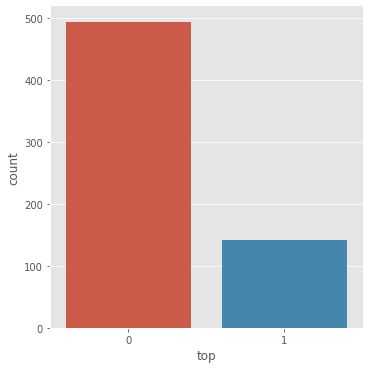

In [33]:
sb.factorplot('top',data=df, kind='count')
#Kind identifica el tipo de grafico que queremos crear 
#Con count significa un grafico de conteo, el numero de observaciones de cada categoria

Visualizamos los atributos de entradas

Vemos cuantos registros hay de tipo de artista

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


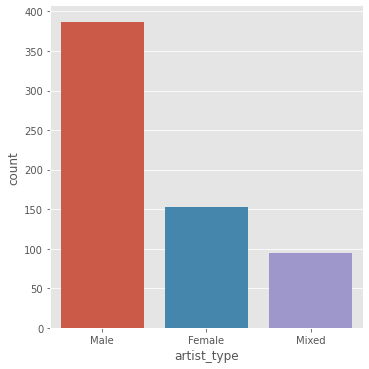

In [34]:
sb.factorplot('artist_type',data=df,kind='count')

Vemos mas del doble de artistas masculinos que femeninos y unos 100 registros de canciones mixtas

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


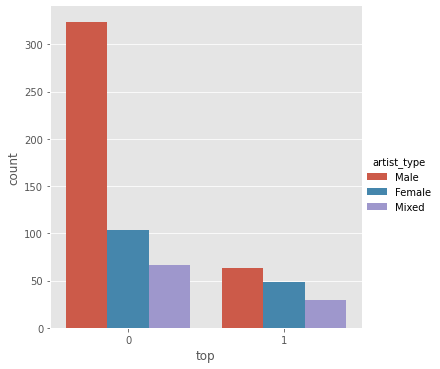

In [35]:
sb.factorplot('top',data=df,hue='artist_type',kind='count')
#Hue se utiliza como una dimension adicional en el grafico, diferenciando los datos por colores

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


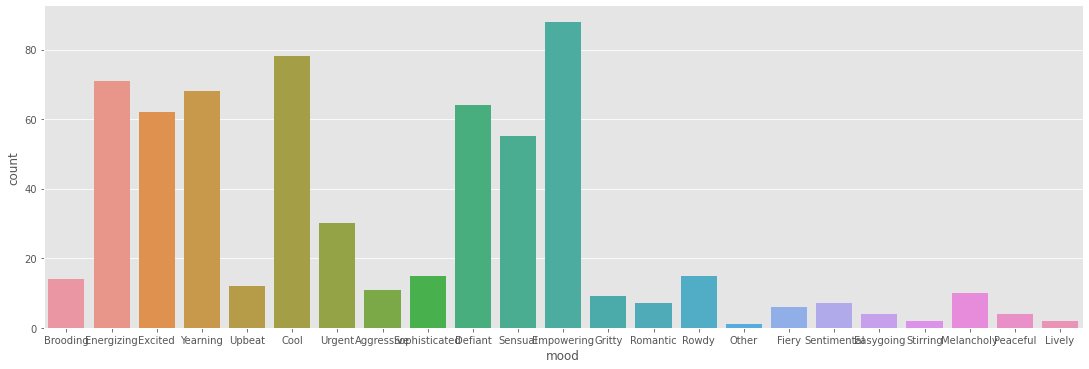

In [36]:
sb.factorplot('mood',data=df,kind='count',aspect=3)
#Aspect 3 determina la relacion de ancho y alto del grafico

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


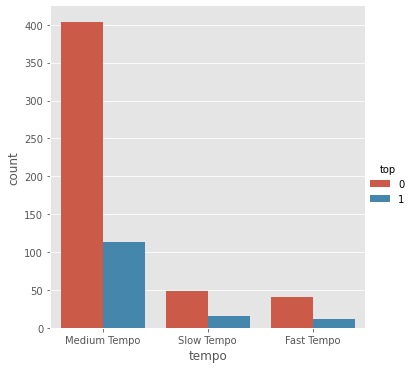

In [37]:
sb.factorplot('tempo',data=df,hue='top',kind='count')

Vemos que hay 3 tipos de Tempo y el que mas predomina son los tiempos Medium, donde también encontramos más canciones que hayan alcanzado el Top 1

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


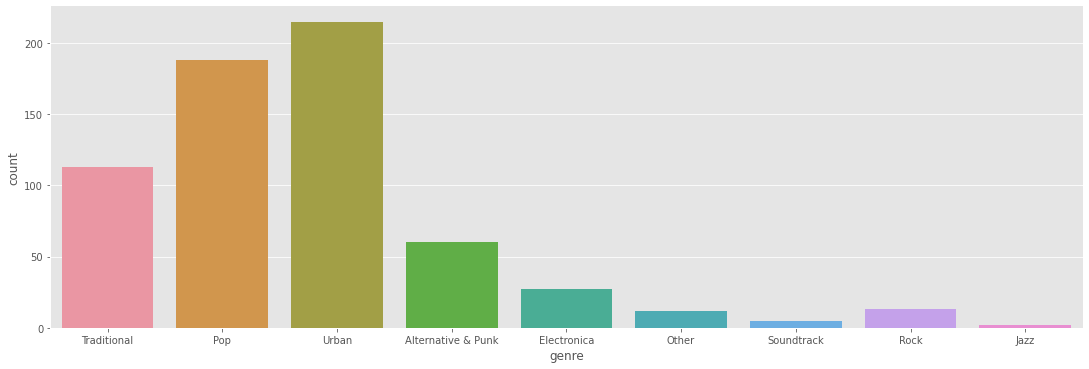

In [38]:
sb.factorplot('genre',data=df,kind='count',aspect=3)

Entre los generos musicales destacan Urban y Pop, seguidos de Tradicional

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


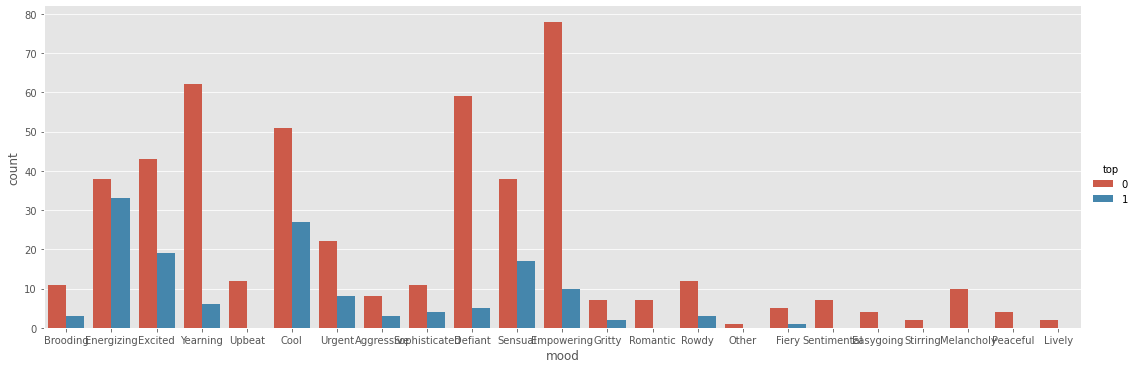

In [39]:
sb.factorplot('mood',data=df,hue='top', kind='count',aspect=3)

Visualicemos los años de nacimientos de los artistas

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


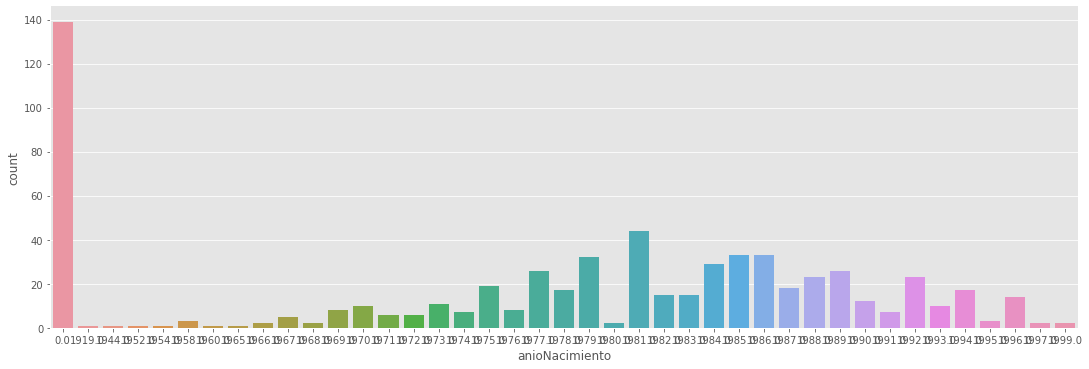

In [40]:
sb.factorplot('anioNacimiento',data=df,kind='count',aspect=3)

In [41]:
nacimientosporanio = df['anioNacimiento']
len(nacimientosporanio[nacimientosporanio<=0])

139

139 registros no conocemos el año del artista, por lo cual debemos tratar estos datos para poder usar el algoritmo de arbol de decision

Comparemos los TOP y No TOP

Buscamos si hay alguna relacion evidente entre Año y Duracion de la cancion

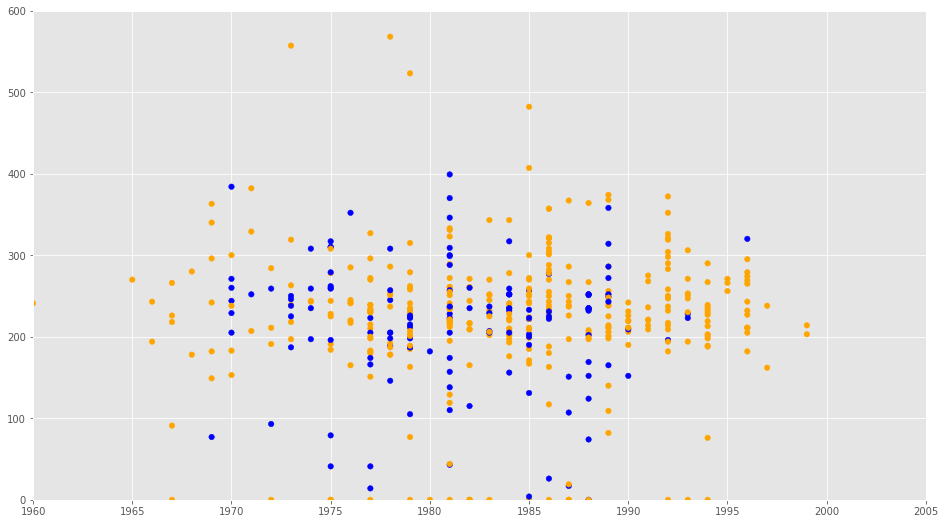

In [42]:
colores = ['orange', 'blue']
tamanios = [60,40]

f1 = df['anioNacimiento'].values
f2 = df['durationSeg'].values

asignar = []
for index,row in df.iterrows():
    asignar.append(colores[row['top']])

plt.scatter(f1,f2,c=asignar, s=30)
plt.axis([1960,2005,0,600])
plt.show()

No parece haber algun patron a la vista

Veamos en que año tenemos Top

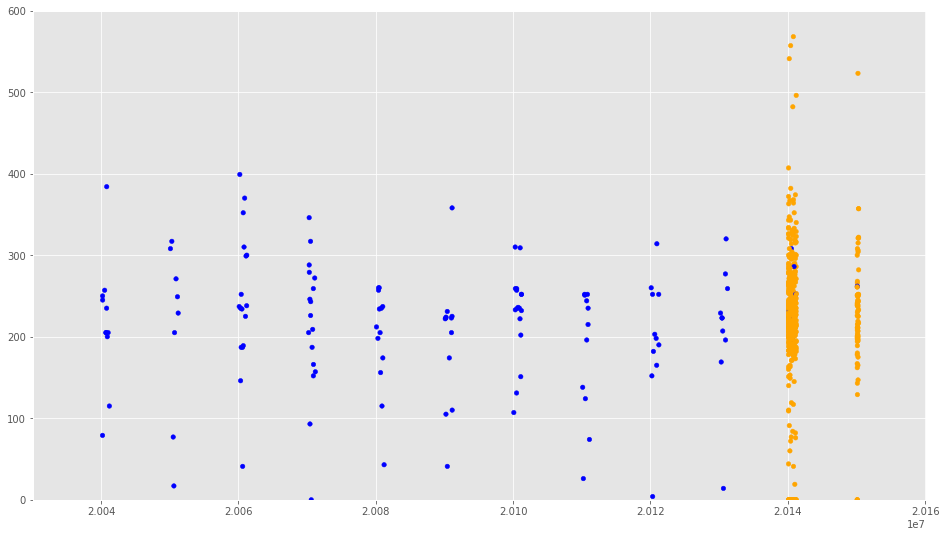

In [47]:
if isinstance(tamanios, (int, float)):
    tamanio_final = tamanios
else:
    tamanio_final = tamanios if len(tamanios) == len(f1) else [20] * len(f1)  # Valor por defecto de 20 si tamanios no coincide en tamaño


f1 = df['chart_date'].values
f2 = df['durationSeg'].values

asignar = []
asignar2 = []
for index,row in df.iterrows():
    asignar.append(colores[row['top']])
    asignar2.append(colores[row['top']])

plt.scatter(f1,f2,c=asignar, s=tamanio_final)
plt.axis([20030101,20160101,0,600])
plt.show()

Esto es porque inicialmente se tomo información de 2014 y 2015 y había casi 500 no-top contra sólo 11 registros top. Entonces se tomo a los artistas que alcanzaron el top entre 2004 y 2013 para sumar casos positivos y equilibrar un poco los datos de entrada. Así y todo, sigue estando desbalanceado.

Entonces ahora debemos preparar nuestros datos